In [1]:
! pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

In [2]:
# import torchvision.transforms as transforms
import open_clip
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
import itertools
#############################################
from PIL import Image
from collections import OrderedDict
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Subset
#############################################
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.eval()
tokenizer = open_clip.get_tokenizer('ViT-B-32')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [4]:
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Context length: 77
Vocab size: 49408


In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_to_rgb at 0x7a410c891d00>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [6]:
transform=preprocess

In [7]:
# Download and load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40, shuffle=True, num_workers=2)

100%|██████████| 170M/170M [02:43<00:00, 1.04MB/s]


In [8]:
# Function to unnormalize and plot images
def imshow(img):
    # Unnormalize the image
    img = img / 2 + 0.5  # Reverse the normalization (mean = 0.5, std = 0.5)
    npimg = img.numpy()  # Convert from tensor to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert to HWC format for displaying
    plt.show()

In [9]:
#Label Description
descriptions = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}

In [10]:
# Load CIFAR-10 train data
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader to fetch batches of images
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)

# Get a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

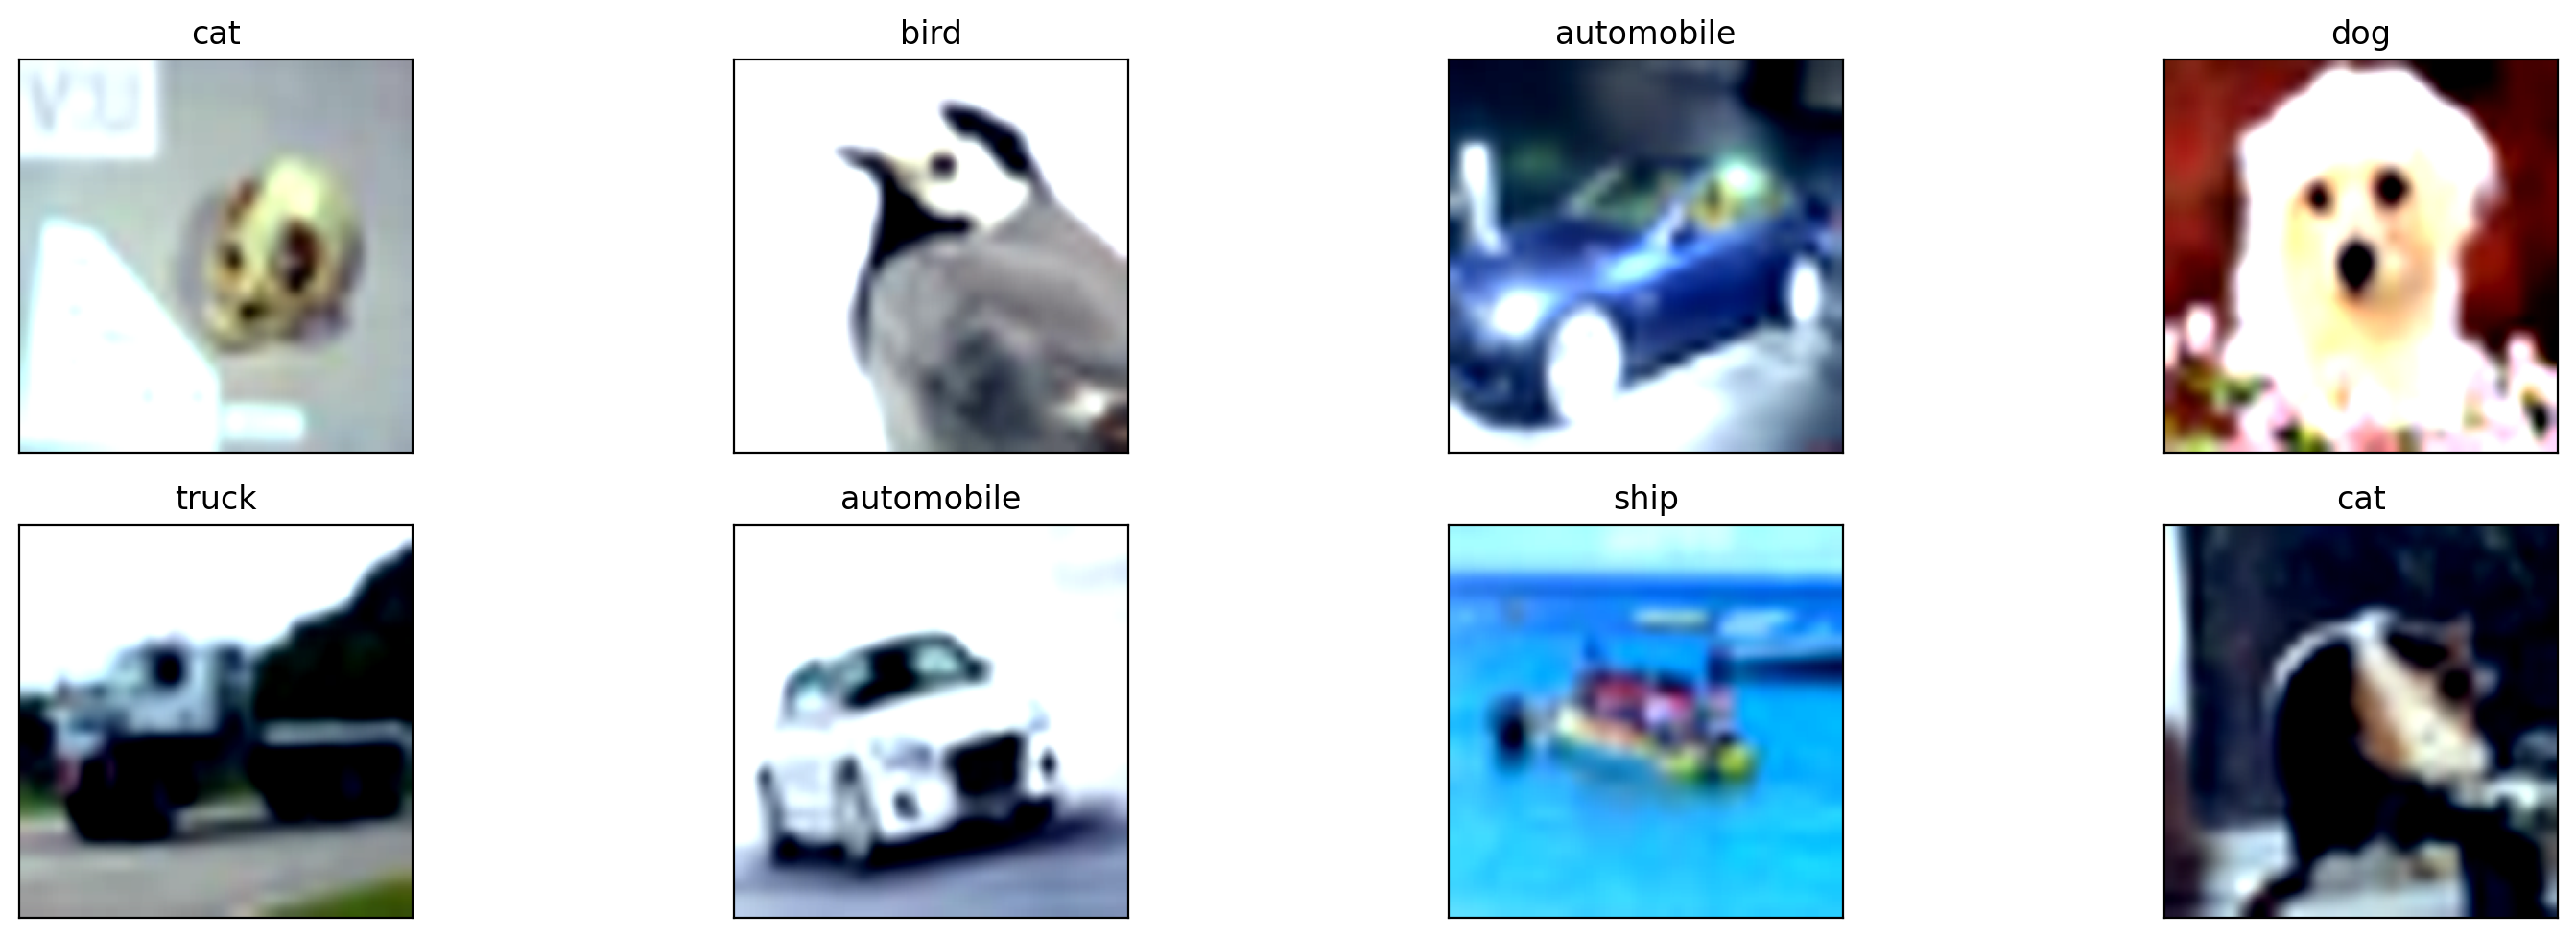

In [11]:
# List to hold original images and their descriptions
original_images = []
images_list = []
texts_image = []
plt.figure(figsize=(16, 5))

# Loop through the batch of images and display them
for i in range(len(images)):
    image = images[i]  # Image tensor
    label = labels[i]  # Corresponding label

    # Unnormalize the image (from [-1, 1] to [0, 1])
    image = image / 2 + 0.5  # Undo normalization

    # Convert tensor to numpy array (H x W x C)
    image = image.numpy().transpose((1, 2, 0))  # Convert from C x H x W to H x W x C

    # Display image with description
    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(f"{descriptions[label.item()]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images_list.append(image)  # If you need to process images, add them here
    texts_image.append(descriptions[label.item()])

plt.tight_layout()
plt.show()

In [12]:
texts1 = [f"A photo of an {descriptions[label.item()]}." for label in np.arange(0,2)]
texts2 = [f"A photo of a {descriptions[label.item()]}." for label in np.arange(2,10)]
texts=list(itertools.chain(texts1, texts2))

In [13]:
texts

['A photo of an airplane.',
 'A photo of an automobile.',
 'A photo of a bird.',
 'A photo of a cat.',
 'A photo of a deer.',
 'A photo of a dog.',
 'A photo of a frog.',
 'A photo of a horse.',
 'A photo of a ship.',
 'A photo of a truck.']

In [14]:
text_tokens = tokenizer(texts)

In [15]:
image_input = torch.tensor(np.stack(images))

In [16]:
image_input.shape

torch.Size([8, 3, 224, 224])

In [17]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

In [18]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

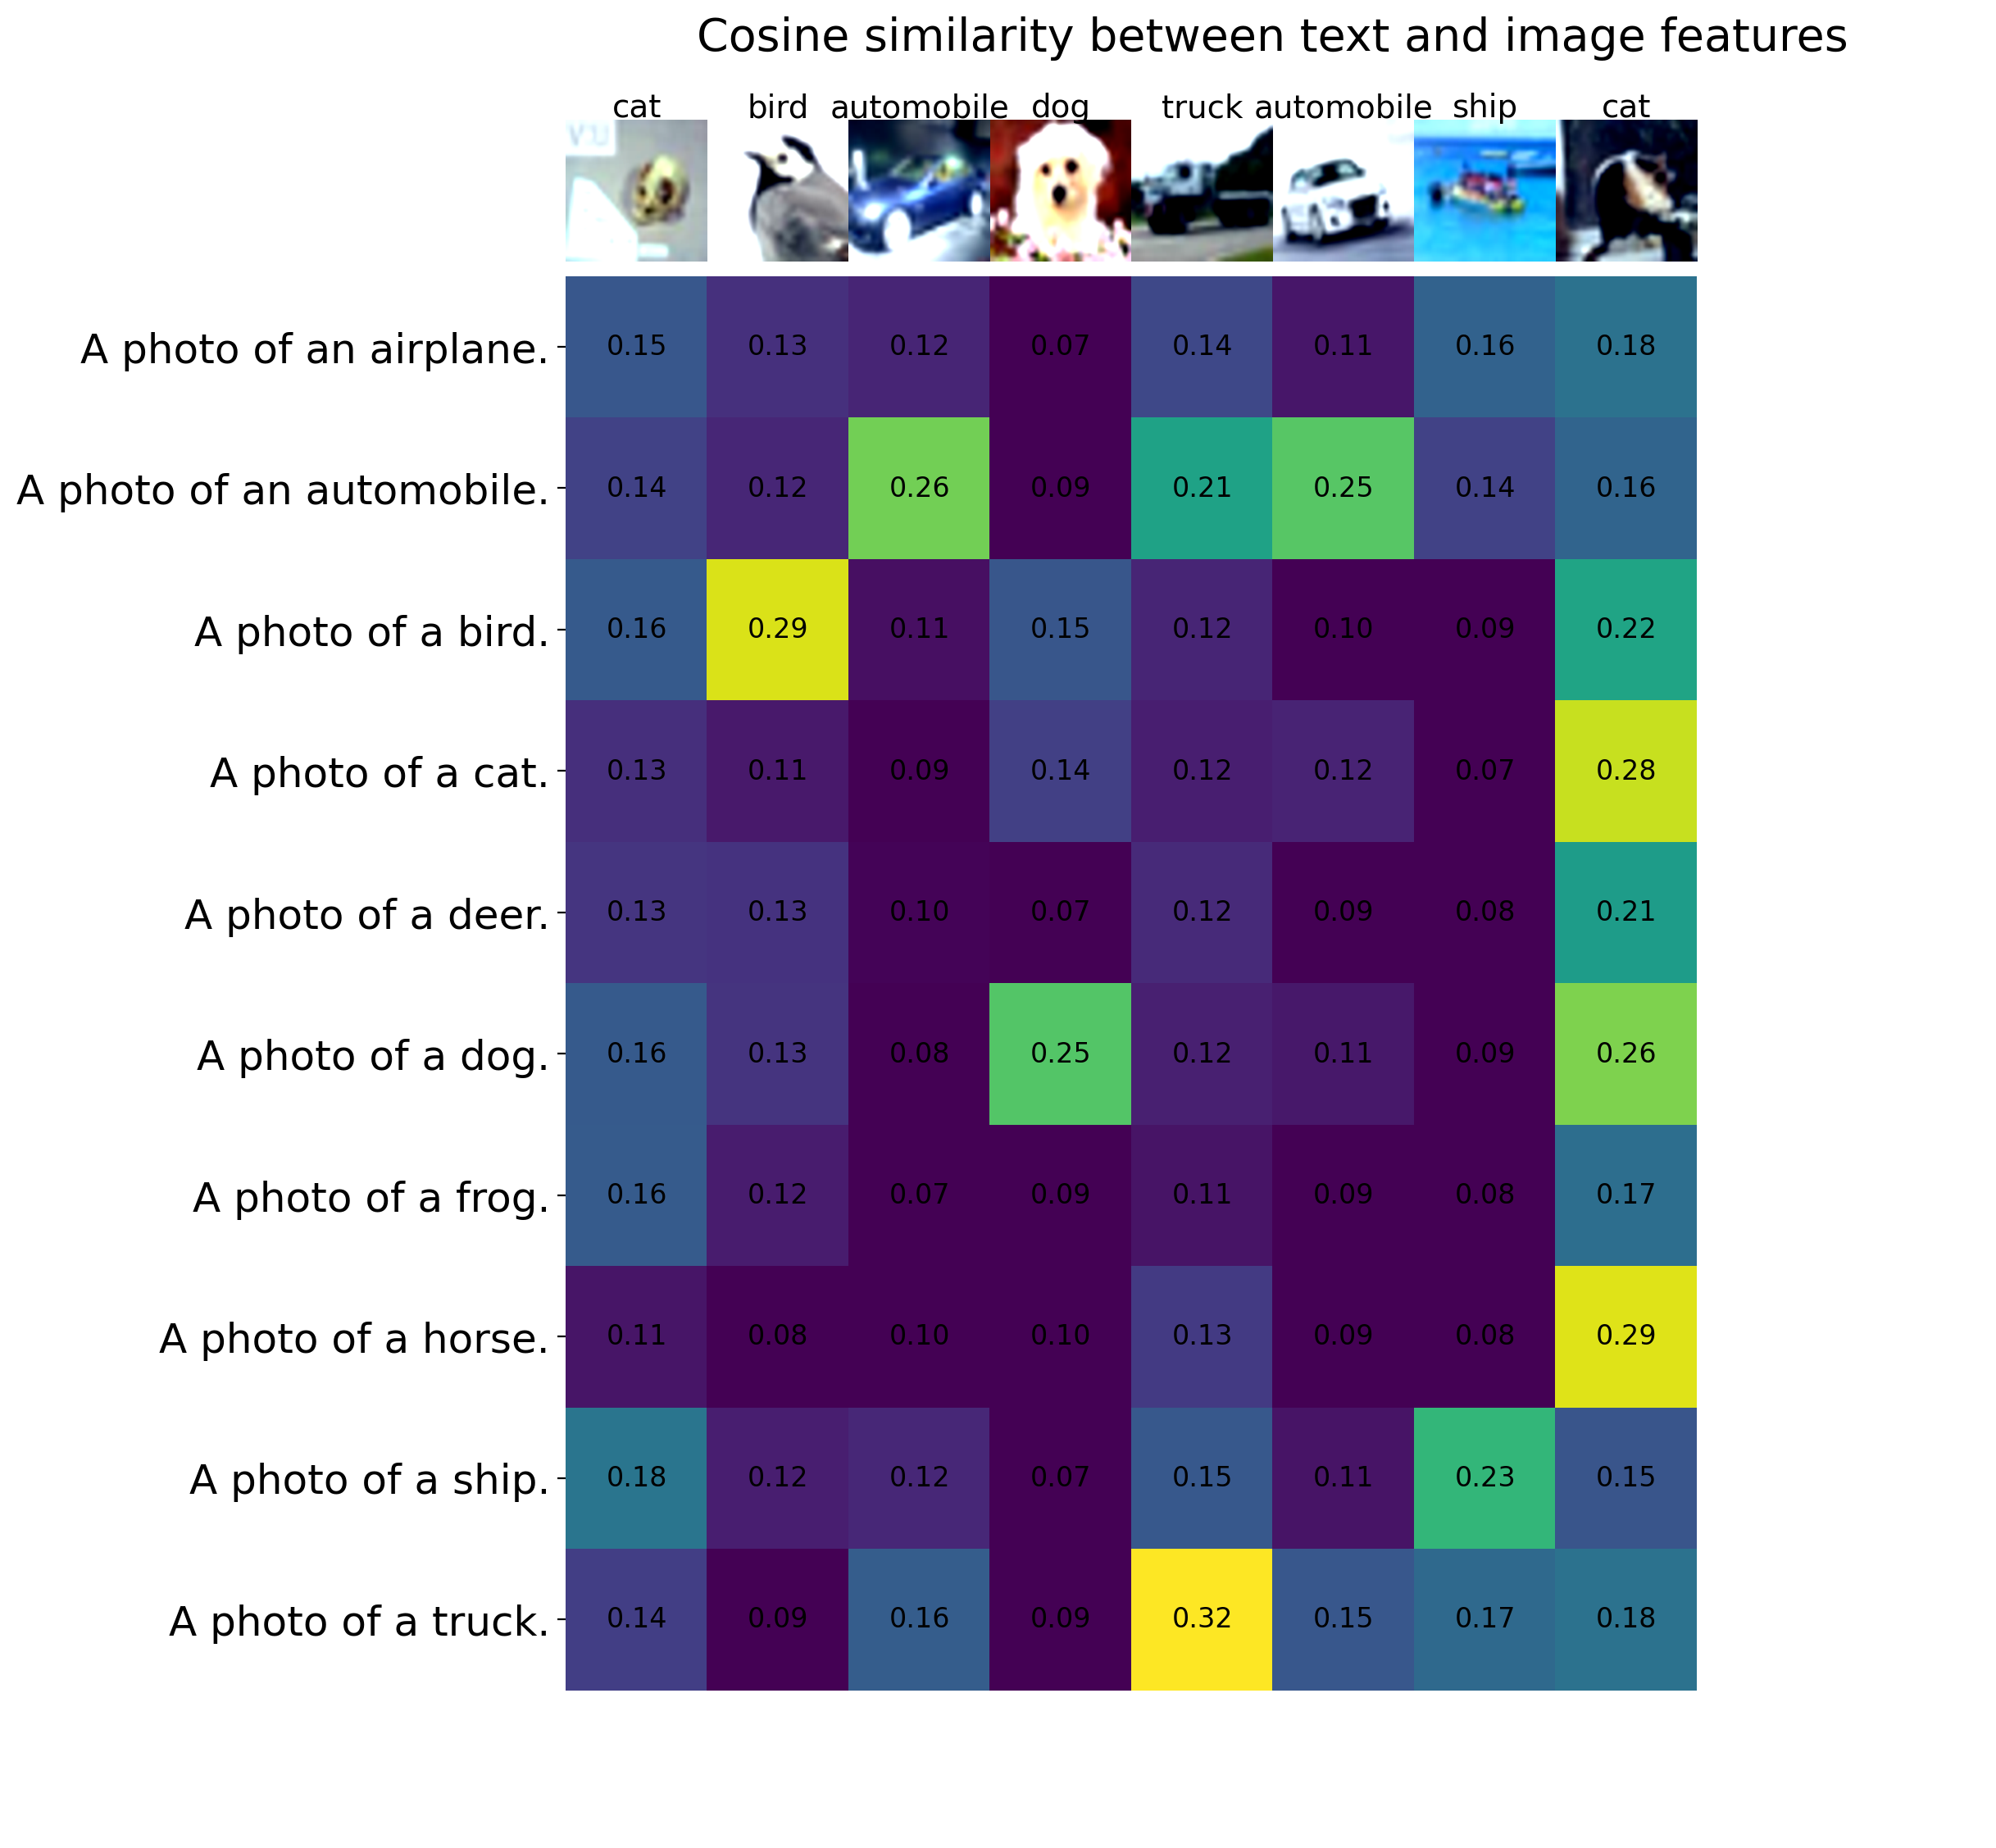

In [19]:
count = len(texts)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

    plt.text(i, -1.8, descriptions[labels[i].item()], ha="center", va="top", fontsize=14, color="black")

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

In [ ]:
ylabel = [f"{descriptions[label.item()]}" for label in np.arange(0,10)]

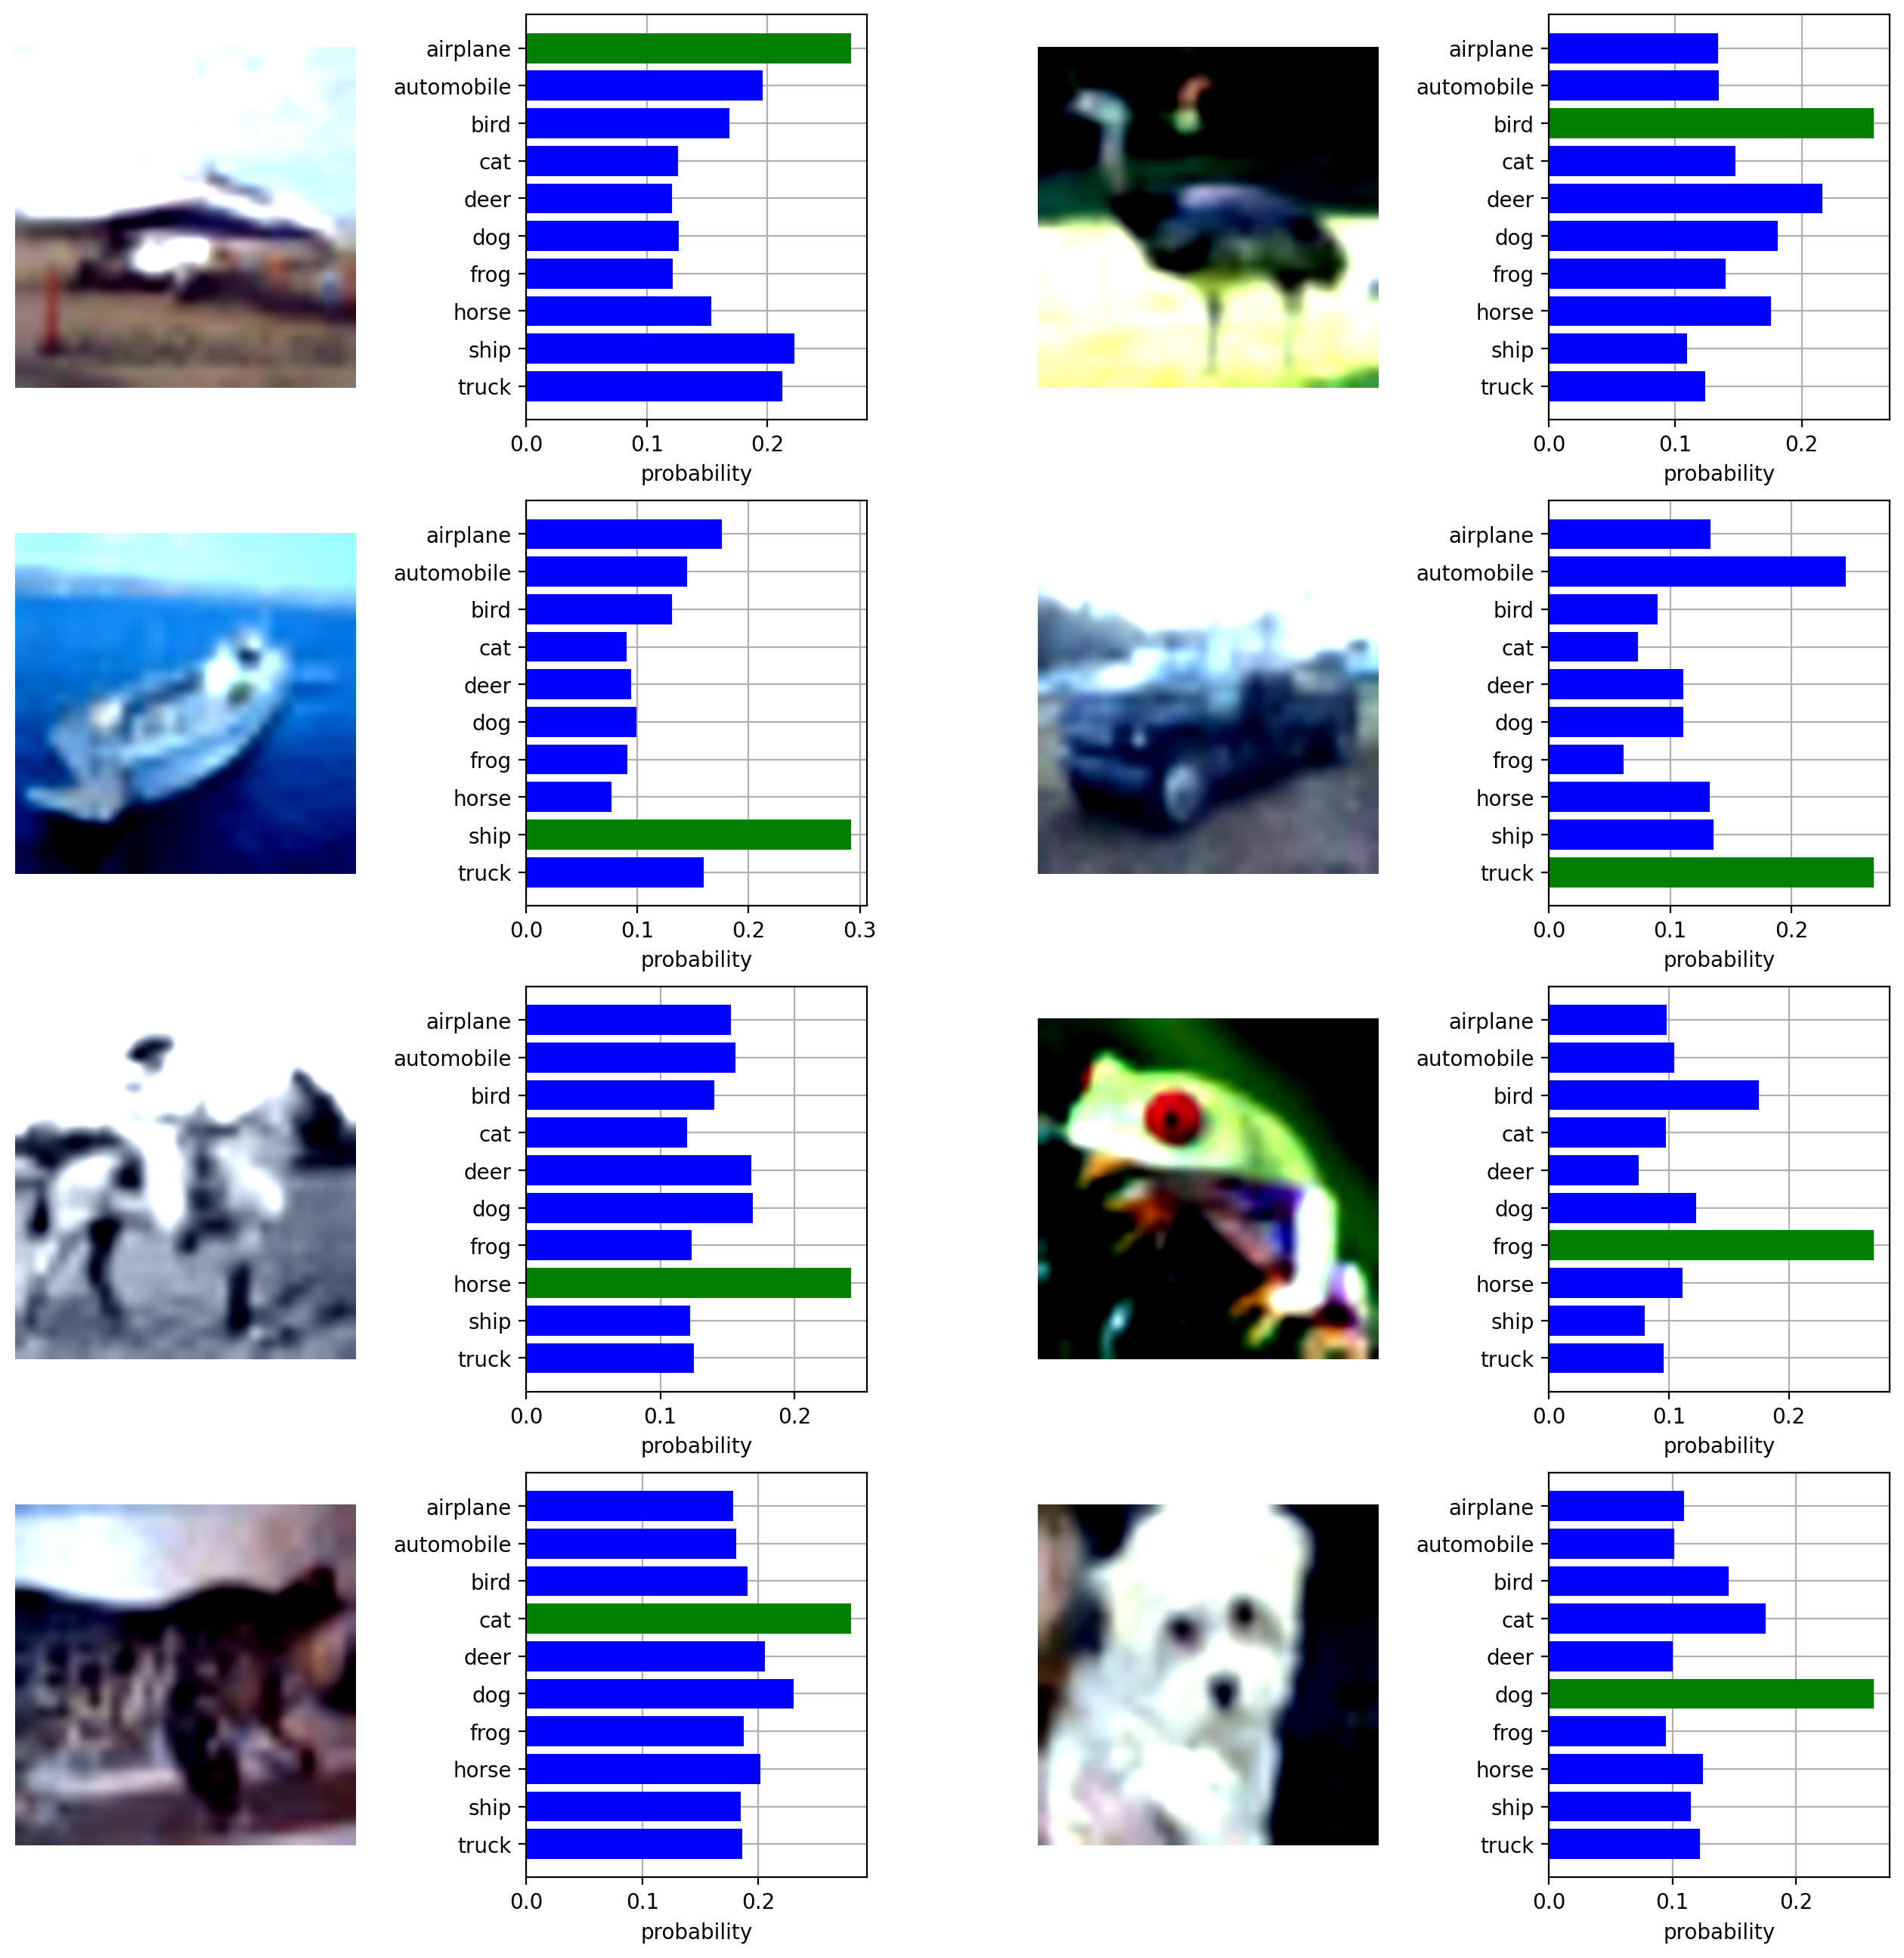

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(similarity.shape[-1])
    plt.grid()
    colors = ['blue'] * 10

    # Change the color of the bar at position 1 (e.g., index 1, which is 'B') to red
    colors[labels[i]] = 'green'

    plt.barh(ylabel, similarity[:,i], color=colors)
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    #plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

In [ ]:
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define the number of samples you want
train_size = 4000  # Set to any value ≤ 50000
subset_indices = list(range(train_size))  # First `train_size` samples

# Create a subset dataset
trainset = Subset(full_trainset, subset_indices)

# Create DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40, shuffle=False, num_workers=2)

In [ ]:
Total_=train_size
Correct1=0
Correct2=0
Correct3=0

num=0

dataiter = iter(trainloader)

for i in range(int(train_size/40)):




  images, labels = next(dataiter)


  image_input = images


  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  #similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T


  # text_features = text_features.to('cuda')  # Move to GPU
  # image_features = image_features.to('cuda')  # Move to GPU

  similarity = text_features @ image_features.T


  Correct1+=torch.sum(similarity.argsort(axis=0)[9]==labels)
  Correct2+=torch.sum(similarity.argsort(axis=0)[8]==labels)
  Correct3+=torch.sum(similarity.argsort(axis=0)[7]==labels)
  num+=40
  if(i%10==0):
    print(i)
    print("=====================================")
    print(Correct1/num)
    print((Correct1+Correct2)/num)
    print((Correct1+Correct2+Correct3)/num)

0
tensor(0.9750)
tensor(1.)
tensor(1.)
10
tensor(0.9432)
tensor(0.9886)
tensor(0.9932)
20
tensor(0.9286)
tensor(0.9810)
tensor(0.9940)
30
tensor(0.9323)
tensor(0.9790)
tensor(0.9935)
40
tensor(0.9335)
tensor(0.9780)
tensor(0.9921)
50
tensor(0.9353)
tensor(0.9794)
tensor(0.9931)
60
tensor(0.9344)
tensor(0.9791)
tensor(0.9930)
70
tensor(0.9345)
tensor(0.9799)
tensor(0.9930)
80
tensor(0.9364)
tensor(0.9802)
tensor(0.9932)
90
tensor(0.9352)
tensor(0.9799)
tensor(0.9923)


In [ ]:
image_features.shape

torch.Size([40, 512])

In [ ]:
print("Top-1 accurac=%f"%(Correct1/Total_))
print("Top-2 accurac=%f"%((Correct1+Correct2)/Total_))
print("Top-3 accurac=%f"%((Correct1+Correct2+Correct3)/Total_))